The principal learning objectives of this tutorial are the following:

1. Model homes that have the similar characteristics to home in the Energy Information Agency's Residential Energy Consumption Survey [1]. 

2. Create models that use correlated random properties

Some the skills you will learn in this tutorial include:

1. How to load and select EIA RECS data.

2. How to refer to Python variables in GLM models.

3. How to run post-simulation analysis

4. How to embed python code in a GLM model

5. How to refer to GLM model variables into Python code

6. How to plot histograms of model properties

7. Generating a GLM model from python code

The principal source of data for this tutorial is the RECS 2015 Microdata [2].  It contains the raw survey data from 2015.  This microdata can be downloaded using the `eia_recs.py` module installed in the GridLAB-D shared folder from the `python_extras` library in the GridLAB-D source code.

# Learning 1: GLM objects with a similar distribution

This first section will illustrate how to obtain a single characteristic from the RECS microdata database and use it to generate a collection of `house` objects that have a similar distribution.

You can load the RECS microdata for the census division that contains the state of California using the following code:

In [1]:
import eia_recs
fips = eia_recs.Microdata.get_division("CA")
codes = eia_recs.Microdata.get_codes(**fips)
recs = eia_recs.Microdata()
data = recs[recs["DIVISION"]==codes["division"]]

data

,DOEID,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,ZTYPEHUQ,CELLAR,ZCELLAR,BASEFIN,...,ZELAMOUNT,NGXBTU,PERIODNG,ZNGAMOUNT,FOXBTU,PERIODFO,ZFOAMOUNT,LPXBTU,PERIODLP,ZLPAMOUNT
30,10031,4,9,METRO,U,2,0,0,0,-2,...,0,98.88,1,0,137.45,-2,-2,91.33,-2,-2
63,10064,4,9,METRO,R,2,0,0,0,-2,...,1,NaN,-2,-2,137.45,-2,-2,91.33,5,1
118,10119,4,9,METRO,U,2,0,0,0,-2,...,0,99.77,1,0,137.45,-2,-2,91.33,-2,-2
135,10136,4,9,METRO,U,2,0,0,0,-2,...,0,85.58,1,0,137.45,-2,-2,91.33,-2,-2
180,10181,4,9,METRO,U,2,0,0,0,-2,...,0,84.81,1,0,137.45,-2,-2,91.33,-2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602,15603,4,9,METRO,U,2,0,0,0,-2,...,0,84.57,1,0,137.45,-2,-2,91.33,-2,-2
5622,15623,4,9,METRO,U,2,0,0,0,-2,...,0,99.40,1,0,137.45,-2,-2,91.33,-2,-2
5637,15638,4,9,METRO,U,2,0,0,0,-2,...,0,99.45,1,0,137.45,-2,-2,91.33,-2,-2
5651,15652,4,9,METRO,U,2,0,0,0,-2,...,0,84.41,1,0,137.45,-2,-2,91.33,5,1


**Skill 1**: The EIA RECS microdata is available from the `eia_recs.py` module that is installed as part of GridLAB-D Python Extras.  The `Microdata` class provides direct access to the entire survey dataset, which includes roughly 750 columns of data for roughly 5700 residential buildings across the US. The `get_division()` and `get_codes()` methods determine the census region, division, and FIPS codes to the state given.  These codes can be used to select records, as shown in the pandas selection used to obtain the `data`.

The `data` object now contains all the records needed to obtain home statistics for census division 9, e.g., the parameters of a log-normal distribution of floor area:

<AxesSubplot:ylabel='Frequency'>

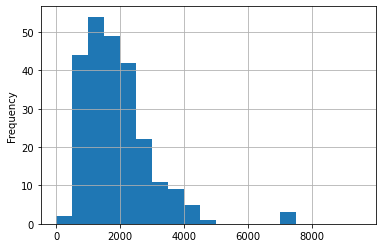

In [18]:
import numpy
avg = numpy.log(data["TOTSQFT_EN"]).mean()
std =  numpy.log(data["TOTSQFT_EN"]).std()

data["TOTSQFT_EN"].plot(kind="hist",bins=range(0,10000,500),grid=True)

These parameters can then be used to generate a collection of `house` objects with the same distribution, e.g., 1000 homes with the same geometric average and standard deviation:

**Skill 2**: You can embed a python value in your GLM model using the syntax `${PYTHON name}` where `name` is the python object you wish to embed.  One caveat is that many objects are represented in formats that are not compatible with GridLAB-D's GLM format. As a result, generally only numbers are represented correctly by default.  Other objects such as strings and lists require special formatting to be represented correctly in GLM files.  This is an advanced topic that will be addressed in another tutorial.

We can verify the result by outputing this model to a JSON file and running a python script to generate a histogram of the result.

**Skill 3**: When a GLM file is loaded, you can use `#on_exit CODE python3 FILENAME.py` command to schedule a post-processing run of a python script.  If the code `0` is used, the script will run only when the GLM file is loaded (and run if that is required) successfully.  The value `-1` allows you to run the scripts if the GLM file load fails. Positive codes refers to specific abnormal exit conditions, such as an error with the command line (1), an error starting the simulation environment (2), a runtime error (5), and an initialization error (6).

Let's put all this together now, and run the GLM model.

First, here's what the GLM file looks like

In [3]:
!cat eia_recs_floorarea.glm

// this prevents the simulation from start a clock
#set compileonly=TRUE
#set warn=FALSE

// load the RECS data and calculate the floor area statistics
#begin python
import eia_recs, numpy
fips = eia_recs.Microdata.get_division("${region}")
codes = eia_recs.Microdata.get_codes(**fips)
recs = eia_recs.Microdata()
data = recs[recs["DIVISION"]==codes["division"]]
avg = numpy.log(data["TOTSQFT_EN"]).mean()
std =  numpy.log(data["TOTSQFT_EN"]).std()
#end

// create the same number of homes with a similar log-normal distribution
module residential;
object house:..${PYTHON len(data)}
{
    floor_area random.lognormal(${PYTHON avg},${PYTHON std});
}

// save and plot the results 
#set savefile=${modelname/.glm/.json}
#on_exit 0 python3 ${modelname/.glm/.py}


**Skill 4**: The python code is embedded in the GLM file using the `#begin python` ... `#end` syntax.  The body of the code between these two statement is compiled into GridLAB-D's main python context and available for use during the loading, initialization, and simulation processes.

**Skill 5**: The python call to `eia_recs.Microdata.get_division("${region}")` uses the string `"${region}"`.  This syntax causes the GLM loaded to substitute the GLM global variable `region` in place so that Python receives the value `"CA"` (assuming the `region` is California).

The python file contains the following code:

In [4]:
!cat eia_recs_floorarea.py

import sys, json
area = []
with open(sys.argv[0].replace(".py",".json"),"r") as f:
    glm = json.load(f)
    for name, data in glm["objects"].items():
        area.append(float(data["floor_area"].split()[0]))
import matplotlib.pyplot as plt
plt.hist(area,20,range=(0,10000))
plt.xlabel("Floor area (sf)")
plt.ylabel("Number of homes")
plt.title(f"Floor areas (N={len(area)})")
plt.grid()
plt.savefig(sys.argv[0].replace(".py",".png"))

**Skill 6**: The JSON files generated by the `#set savefile=FILENAME.json` command above has a specific structure that allows python scripts to access any property of any object in the model.  In this case, we can all the objects and extract the `floor_area` property to construct a list that we can plot as a histogram using `matplotlib`.

The output PNG file is generated and viewed using the following command

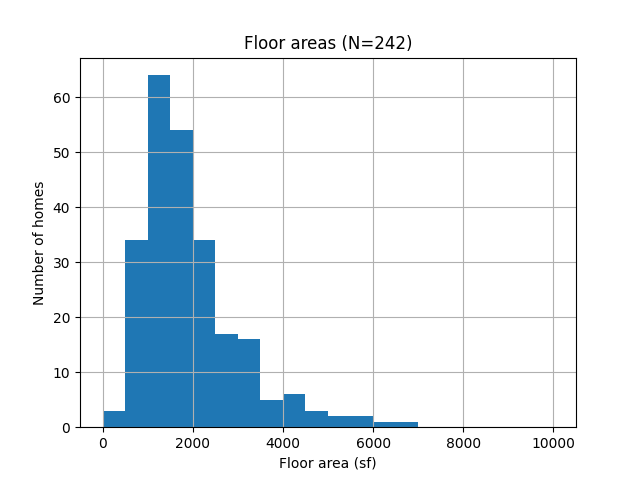

In [5]:
!gridlabd eia_recs_floorarea.glm
from PIL import Image
Image.open("eia_recs_floorarea.png")

# Learning 2: GLM objects with correlated distributions


In this section we will learn how to generate and verify a correlated distribution of properties from the RECS dataset, specifically the floor area and the thermal integrity. Because this is a discrete property, a discrete correlated distribution method is used.

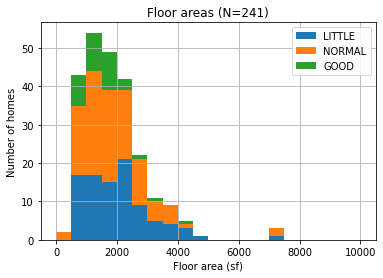

In [6]:
import eia_recs, numpy
fips = eia_recs.Microdata.get_division("CA")
codes = eia_recs.Microdata.get_codes(**fips)
recs = eia_recs.Microdata()
data = recs[recs["DIVISION"]==codes["division"]]
area = {}
ins = []
avg = []
std = []
keys = ["LITTLE","NORMAL","GOOD"]
for n in range(1,4):
    ins.append(data[data["ADQINSUL"]==n])
    area[keys[n-1]] = list(ins[-1]["TOTSQFT_EN"])
    avg.append(numpy.log(ins[-1]["TOTSQFT_EN"]).mean())
    std.append(numpy.log(ins[-1]["TOTSQFT_EN"]).std())
values = list(area.values())
keys = list(area.keys())
import sys, matplotlib.pyplot as plt
plt.hist(area.values(),20,range=(0,10000),label=keys,stacked=True)
plt.xlabel("Floor area (sf)")
plt.ylabel("Number of homes")
plt.title(f"Floor areas (N={sum(list(map(lambda x:len(x),values)))})")
plt.grid()
plt.legend(list(area.keys()))
plt.show()

The GLM file for a model based on this data is as follows

In [7]:
!cat eia_recs_floorarea_insulation.glm

// this prevents the simulation from start a clock
#set compileonly=TRUE
#set warn=FALSE

// load the RECS data and calculate the floor area statistics
#begin python
import eia_recs, numpy
fips = eia_recs.Microdata.get_division("${region}")
codes = eia_recs.Microdata.get_codes(**fips)
recs = eia_recs.Microdata()
data = recs[recs["DIVISION"]==codes["division"]]
ins = []
avg = []
std = []
for n in range(1,4):
    ins.append(data[data["ADQINSUL"]==n])
    avg.append(numpy.log(ins[-1]["TOTSQFT_EN"]).mean())
    std.append(numpy.log(ins[-1]["TOTSQFT_EN"]).std())
#end

// create the same number of homes with a similar log-normal distribution
module residential;
object house:..${PYTHON len(ins[0])}
{
    floor_area random.lognormal(${PYTHON avg[0]},${PYTHON std[0]});
    thermal_integrity_level GOOD;
}
object house:..${PYTHON len(ins[1])}
{
    floor_area random.lognormal(${PYTHON avg[1]},${PYTHON std[1]});
    thermal_integrity_level NORMAL;
}
object house:..${PYTHON len(ins[2])}

    floor_

The python script is a little different because we have to plot a stacked histogram:

In [8]:
!cat eia_recs_floorarea_insulation.py

import sys, json, math
area = []
with open(sys.argv[0].replace(".py",".json"),"r") as f:
    glm = json.load(f)
    area = {"LITTLE":[],"NORMAL":[],"GOOD":[]}
    for name, data in glm["objects"].items():
        area[data["thermal_integrity_level"]].append(float(data["floor_area"].split()[0]))
import matplotlib.pyplot as plt
values = list(area.values())
keys = list(area.keys())
plt.hist(values,20,range=(0,10000),label=keys,stacked=True)
plt.xlabel("Floor area (sf)")
plt.ylabel("Number of homes")
plt.title(f"Floor areas (N={len(glm['objects'].keys())})")
plt.grid()
plt.legend(keys)
plt.savefig(sys.argv[0].replace(".py",".png"))

The result is as follows:

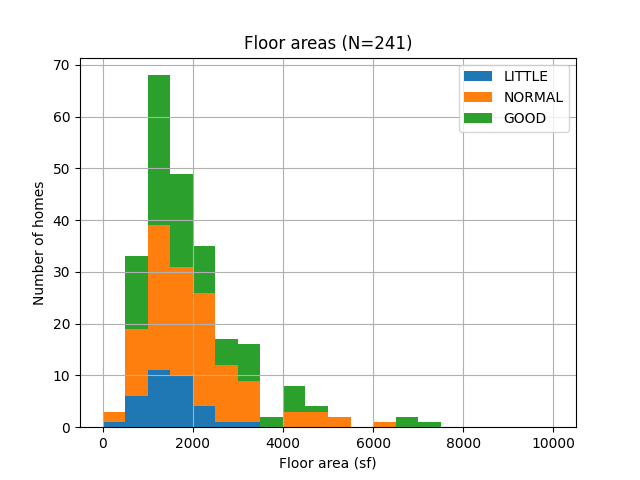

In [9]:
!gridlabd eia_recs_floorarea_insulation.glm
from PIL import Image
Image.open("eia_recs_floorarea_insulation.png")

Another pair of properties that are usually correlated are the heating and cooling setpoints. In this case, the correlation is between two continuous variables, as shown by the following 2D histogram.

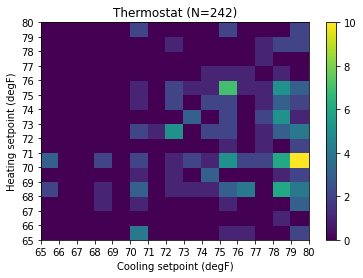

In [10]:
import eia_recs, numpy
fips = eia_recs.Microdata.get_division("CA")
codes = eia_recs.Microdata.get_codes(**fips)
recs = eia_recs.Microdata()
data = recs[recs["DIVISION"]==codes["division"]]
th = data["TEMPHOME"]
tc = data["TEMPHOMEAC"]
import matplotlib.pyplot as plt
plt.hist2d(x=tc,y=th,bins=15,range=[[65,80],[65,80]])
plt.xlabel("Cooling setpoint (degF)")
plt.ylabel("Heating setpoint (degF)")
plt.title(f"Thermostat (N={len(data)})")
plt.colorbar()
plt.xticks(range(65,81,1))
plt.yticks(range(65,81,1))
plt.show()

In this case we will use random sampling to populate the objects in the model. One way this can be accomplished to is to generate the objects in a separate file and include the file. 

The following GLM file creates a model with 1000 homes (instead of the original 242).

In [11]:
!cat eia_recs_floorarea_temperature.glm

// this prevents the simulation from start a clock
#set compileonly=TRUE
#set warn=FALSE

// load the RECS data and calculate the floor area statistics
#begin python
import eia_recs, numpy, sys, random
fips = eia_recs.Microdata.get_division("${region}")
codes = eia_recs.Microdata.get_codes(**fips)
recs = eia_recs.Microdata()
data = recs[recs["DIVISION"]==codes["division"]]
th = list(data["TEMPHOME"])
tc = list(data["TEMPHOMEAC"])
with open("/tmp/objects.glm","w") as f:
    f.write("module residential;\n")
    for n in range(1000):
        f.write("object house {\n")
        m = random.randrange(len(data))
        f.write(f"  heating_setpoint {th[m]};\n")
        f.write(f"  cooling_setpoint {tc[m]};\n")
        f.write("}\n")
#end

// create the same number of homes with a similar log-normal distribution
#include "/tmp/objects.glm"

// save and plot the results 
#set savefile=${modelname/.glm/.json}
#on_exit 0 python3 ${modelname/.glm/.py}


**Skill 7**: Dynamically generated models can be written to a temporary GLM file and then loaded using a `#include` statement.  Care should be take not to use a filename that is already used.  An alternative method is to use `modify` statements instead of `object` statements.

Here again, a familiar python script is used to analyze the result:

In [12]:
!cat eia_recs_floorarea_temperature.py

import sys, json, math
th = []
tc = []
with open(sys.argv[0].replace(".py",".json"),"r") as f:
    glm = json.load(f)
    for name, data in glm["objects"].items():
        th.append(float(data["heating_setpoint"].split()[0]))
        tc.append(float(data["cooling_setpoint"].split()[0]))

import matplotlib.pyplot as plt
plt.hist2d(x=tc,y=th,bins=15,range=[[65,80],[65,80]])
plt.xlabel("Cooling setpoint (degF)")
plt.ylabel("Heating setpoint (degF)")
plt.title(f"Thermostat (N={len(glm['objects'].keys())})")
plt.colorbar()
plt.xticks(range(65,81,1))
plt.yticks(range(65,81,1))
plt.savefig(sys.argv[0].replace(".py",".png"))

The result is as follows:

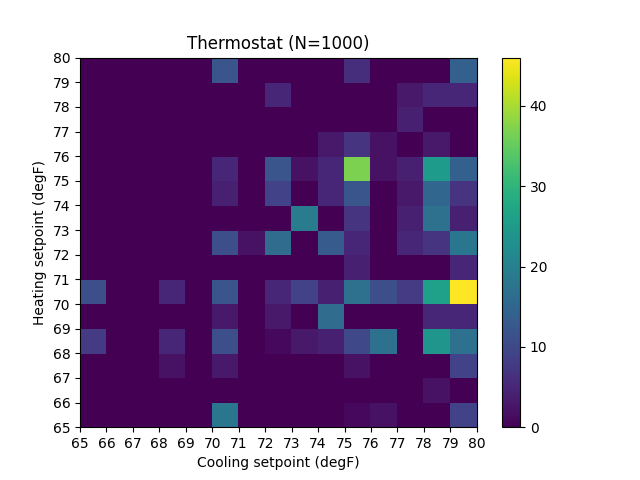

In [13]:
!gridlabd eia_recs_floorarea_temperature.glm
from PIL import Image
Image.open("eia_recs_floorarea_temperature.png")

# References
 [1] Energy Information Agency, "Residential Energy Consumption Survey (RECS)", accessed 29 August 2021. URL: https://www.eia.gov/consumption/residential/.
 
 [2] Energy Information Agency, "RECS 2015 Microdata Version 4", accessed 29 August 2021. URL: https://www.eia.gov/consumption/residential/data/2015/csv/recs2015_public_v4.csv